In [1]:
import warnings
from pathlib import Path

import cartopy.crs as ccrs
import iris
import iris.analysis
import iris.coord_categorisation
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from aeolus.coord import add_cyclic_point_to_cube

In [3]:
from commons import EXPERIMENTS, LAYERS, SEASONS
from mypaths import path_to_results, path_to_ukca
from plot_func import use_paper_style  # use_draft_style
from proc_func import GASES

In [4]:
warnings.filterwarnings("ignore", module="iris")
use_paper_style()
# use_draft_style()

In [5]:
# Choose experiments
exp_name = "FIRE"
# Choose layer
layer = "BL"  # BL or FT

In [6]:
cl = iris.cube.CubeList()
for gas_name, gasdict in GASES.items():
    if gasdict["noy"]:
        # Load mass mixing ratios [kg kg-1] of NOy species and convert them to volume mixing ratios [ppb]
        cb = (
            iris.load_cube(
                str(
                    path_to_ukca / EXPERIMENTS[exp_name] / f"{EXPERIMENTS[exp_name]}_{gas_name}.nc"
                ),
                f"{gas_name}",
            )
            * GASES[gas_name]["mmr_to_vmr"]
            * 1e9
        )
        cb.rename(gas_name)

        # Remove the first year of data as a spin up
        if exp_name == "FIRE":
            # Remove faulty data from FIRE (xojnv) simulation
            cb_trimmed = iris.cube.CubeList([cb[12:72, ...], cb[84:120, ...]]).concatenate()[0]
        else:
            cb_trimmed = cb[12::, ...]

        cl.append(cb_trimmed)

In [7]:
# Calculate NOy sum
noy = sum(cl)
noy.rename("noy")

# Add additional time coordinates
iris.coord_categorisation.add_season(noy, "time", name="season")
iris.coord_categorisation.add_season_year(noy, "time", name="year")

In [8]:
# Calculate RONO2 sum
rono2 = sum(cl.extract(["meono2", "etono2", "nprono2", "iprono2"]))
rono2.rename("rono2")

# Add additional time coordinates
iris.coord_categorisation.add_season(rono2, "time", name="season")
iris.coord_categorisation.add_season_year(rono2, "time", name="year")

# Note: RONO2 concentrations are zero in the BASE experiment

In [9]:
def calc_seasonal_mean_in_layer(cube, season, layer):
    """Calculate seasonal mean in a specified layer and add a cyclic longitude."""
    SEASON = iris.Constraint(season=season)
    cb = cube.extract(SEASON & layer).collapsed(["season", "level_height"], iris.analysis.MEAN)
    cyclic_cb = add_cyclic_point_to_cube(cb)
    return cyclic_cb

In [10]:
# Calculate NOy and RONO2 seasonal means in a layer
noy_by_ssn = iris.cube.CubeList()
rono2_by_ssn = iris.cube.CubeList()
for ssn in SEASONS:
    noy_by_ssn.append(calc_seasonal_mean_in_layer(noy, ssn, LAYERS[layer]["iris_constr"]))
    rono2_by_ssn.append(calc_seasonal_mean_in_layer(rono2, ssn, LAYERS[layer]["iris_constr"]))

In [11]:
# Calculate RONO2 contribution to NOy [%]
rono2_pct_of_noy = iris.cube.CubeList()
for icb, jcb in zip(noy_by_ssn, rono2_by_ssn):
    rono2_pct_of_noy.append(jcb * 100 / icb)

In [12]:
# Horizontal grid
lats = cb.coord("latitude").points
lons = noy_by_ssn[0].coord("longitude").points

In [13]:
np.max(rono2_pct_of_noy[0].data), np.max(rono2_pct_of_noy[1].data), np.max(
    rono2_pct_of_noy[2].data
), np.max(rono2_pct_of_noy[3].data)

(0.059327234, 0.10063329, 0.37492934, 0.5206858)

BL:
- CHEM: (29.165516, 32.73719, 37.276176, 30.785294)
- MARI: (77.07162, 73.26048, 52.571236, 52.57894)
- FIRE: (0.059327234, 0.10063329, 0.37492934, 0.5206858)
- FULL: (78.401306, 75.53361, 57.15821, 57.527298)

In [14]:
def plt_ssn_means(exp_name, cubelist, lons, lats):
    from commons import SEASONS

    if exp_name == "FIRE":
        map_kw = dict(
            transform=ccrs.PlateCarree(), cmap="Purples", levels=np.arange(0, 0.65, 0.05),
        )
    else:
        map_kw = dict(transform=ccrs.PlateCarree(), cmap="Purples", levels=np.arange(0, 110, 10),)

    fig, axes = plt.subplots(
        nrows=4,
        ncols=1,
        figsize=(6, 12),
        subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0)),
    )
    for cube, ssn, ax in zip(cubelist, SEASONS, axes.flatten()):
        p0 = ax.contourf(lons, lats, cube.data, **map_kw)
        ax.coastlines(color="k")
        ax.set_title(ssn.upper(), loc="left", y=0.89)
    axes[0].set_title(exp_name, x=0.28, weight="bold")
    axes[0].set_title(LAYERS[layer]["tex"], loc="right", weight="bold")

    cax = fig.add_axes([0.245, 0.1, 0.53, 0.01])
    fig.colorbar(p0, cax=cax, orientation="horizontal", label="$RONO_2$ contribution to $NO_y$, %")
    fig.subplots_adjust(hspace=0.05)
    figname = f"{exp_name.lower()}_rono2_pct_of_noy"
    fig.savefig(path_to_results / "xojn" / "rono2_in_noy" / figname)

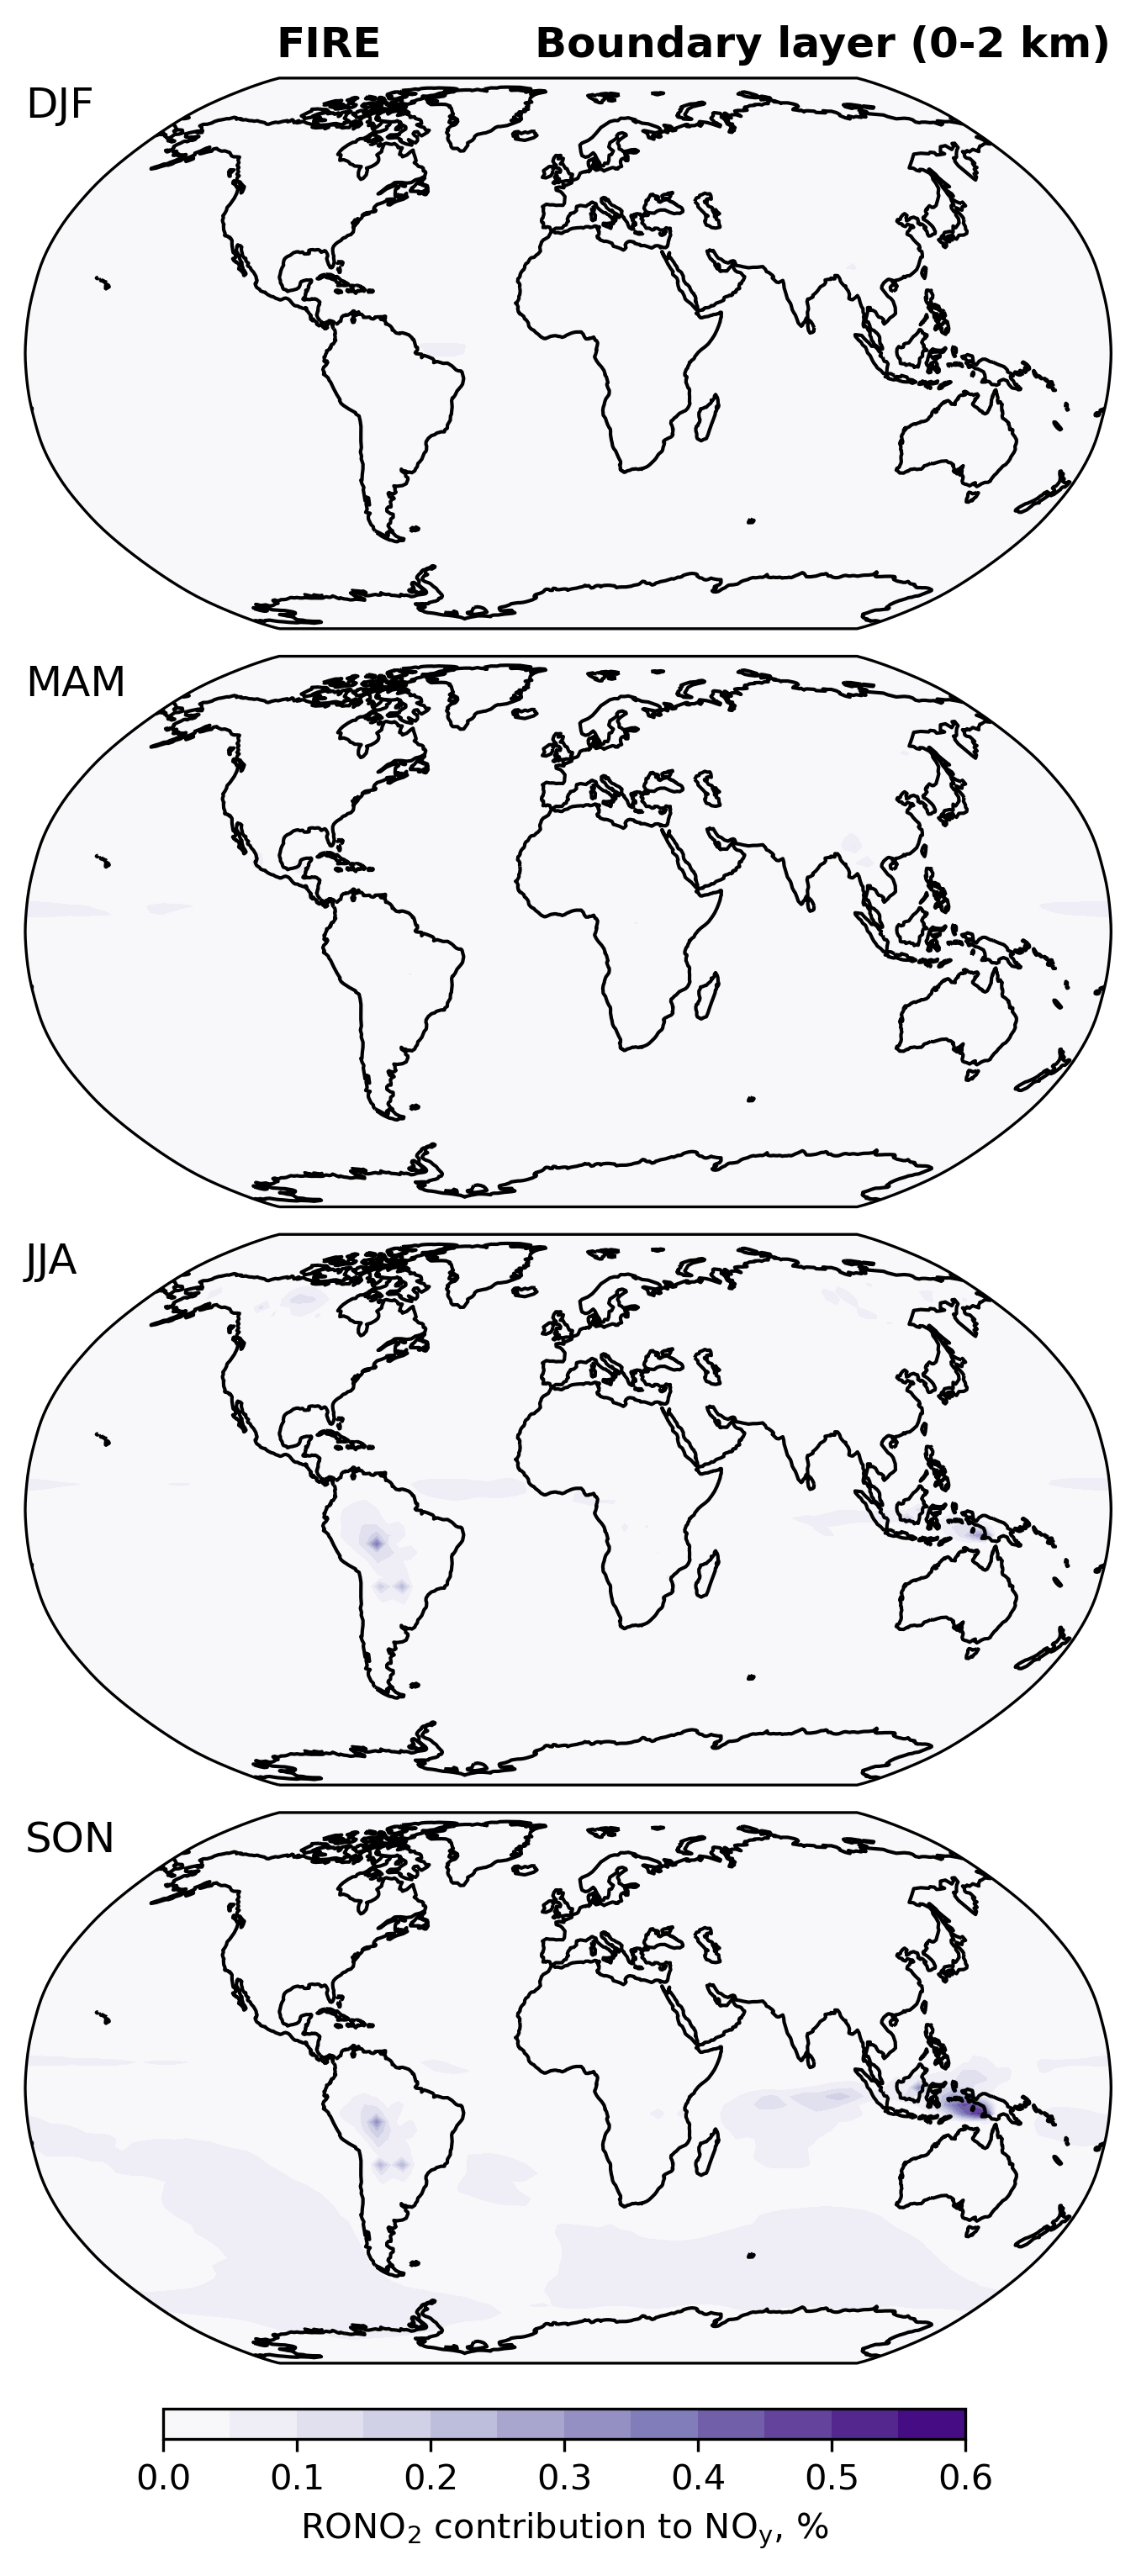

In [15]:
plt_ssn_means(exp_name, rono2_pct_of_noy, lons, lats)